# Sentiment Analysis

In [264]:
from dotenv import dotenv_values
import requests
import json
import tweepy

import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\blancc2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [265]:
config = dotenv_values(".env")

bearer_token = config["BEARER_TOKEN"]
consumer_key = config["API_KEY"]
consumer_secret = config["API_KEY_SECRET"]

In [266]:
tweets_folder = Path("data/Tweets_Data")

In [267]:
#print(config["API_KEY"])

In [268]:
client = tweepy.Client( bearer_token=bearer_token, 
                        consumer_key=consumer_key, 
                        consumer_secret=consumer_secret, 
                        return_type = requests.Response,
                        wait_on_rate_limit=True)

In [269]:
def search_agricultural_tweets(country_name,max_results=100):
    
    if country_name is None: 
        tweets = client.search_recent_tweets(query="((agricultural) OR (agriculture)) lang:en -is:retweet", 
                                    tweet_fields=['author_id', 'created_at'],
                                     max_results=max_results)
    else:
        tweets = client.search_recent_tweets(query="((agricultural) OR (agriculture)) ("+country_name+") lang:en -is:retweet", 
                                        tweet_fields=['author_id', 'created_at'],
                                         max_results=max_results)
    tweets_dict = tweets.json()
    tweets_data = tweets_dict['data']
    return pd.json_normalize(tweets_data)    

In [270]:
max_results=100
country1 = 'Ireland'

tweets_c1_df = search_agricultural_tweets(country1, max_results)
tweets_c2_df = search_agricultural_tweets(None, max_results)

In [271]:
#Citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

In [343]:
#target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
tweets_train_df = pd.read_csv(tweets_folder /"tweets_sentiment.csv", encoding='latin-1', names=["sentiment", "id", "date", "flag", "user", "text"])

In [344]:
tweets_train_df.head()

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


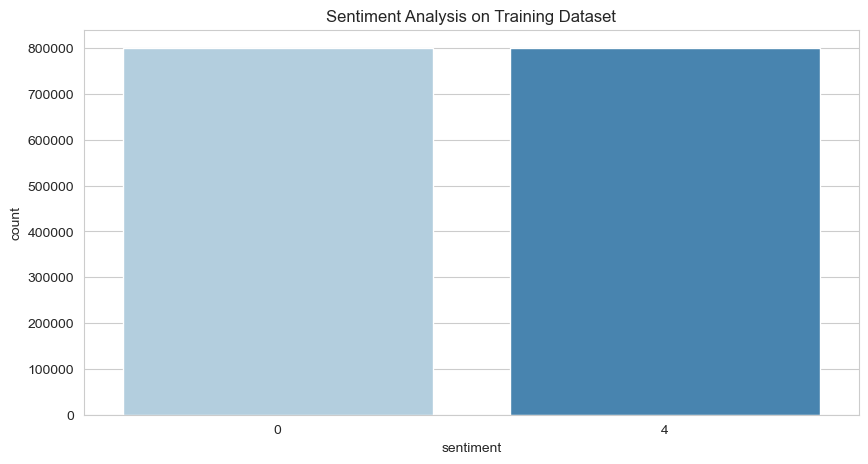

In [345]:
plt.figure(figsize=(10,5))
g = sns.countplot(x='sentiment',data=tweets_train_df, palette='Blues');
g.set_title('Sentiment Analysis on Training Dataset')

plt.show();



In [309]:
#Data balanced.

def get_text_processing(text):
    #Remove any user mention (word starting by "@")
    no_user=[word for word in text.split() if not word.startswith("@")]
    text = ' '.join(no_user)
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [310]:
tweets_train_df=tweets_train_df.sample(n = 30000)
tweets_train_df

,sentiment,id,date,flag,user,text
186271,0,1968263800,Fri May 29 21:05:10 PDT 2009,NO_QUERY,Meli_mel_mel,"Whoa, my nails are so long! I dont bite them a..."
83269,0,1753299494,Sun May 10 00:58:59 PDT 2009,NO_QUERY,callmefrenchie,Ahh! My eye hurts I think I have a pretty ba...
1312443,4,2013655880,Tue Jun 02 23:13:23 PDT 2009,NO_QUERY,MsCoLo,@stephjonesmusic Either way if water is involv...
761006,0,2297038139,Tue Jun 23 09:57:02 PDT 2009,NO_QUERY,neekbreek,@toastcommunism i think that's for the store t...
1337030,4,2017463276,Wed Jun 03 08:25:56 PDT 2009,NO_QUERY,Malteboy777,@AFineFrenzy - You know? I'm soo jalous that ...
...,...,...,...,...,...,...
377911,0,2051989712,Fri Jun 05 23:20:29 PDT 2009,NO_QUERY,juumoraes,http://twitpic.com/6q8jl - me and danny
420430,0,2062207930,Sat Jun 06 22:36:18 PDT 2009,NO_QUERY,ohfuckmylife,OH: fml @brittdainard knows what i;m doing ev...
58719,0,1685964748,Sun May 03 03:01:28 PDT 2009,NO_QUERY,witch_fairy,I'm so bored. My life is getting busy now... ...
1314658,4,2013933168,Tue Jun 02 23:59:22 PDT 2009,NO_QUERY,mytryheart,lol... there's a blackout here! i'm in a middl...


In [311]:
tweets_train_df['processed_text'] = tweets_train_df['text'].apply(get_text_processing)
tweets_train_df.head()

,sentiment,id,date,flag,user,text,processed_text
186271,0,1968263800,Fri May 29 21:05:10 PDT 2009,NO_QUERY,Meli_mel_mel,"Whoa, my nails are so long! I dont bite them a...",Whoa nails long dont bite anymore keep breaking
83269,0,1753299494,Sun May 10 00:58:59 PDT 2009,NO_QUERY,callmefrenchie,Ahh! My eye hurts I think I have a pretty ba...,Ahh eye hurts think pretty bad stye
1312443,4,2013655880,Tue Jun 02 23:13:23 PDT 2009,NO_QUERY,MsCoLo,@stephjonesmusic Either way if water is involv...,Either way water involved results would nasty
761006,0,2297038139,Tue Jun 23 09:57:02 PDT 2009,NO_QUERY,neekbreek,@toastcommunism i think that's for the store t...,think thats store thats anaheim though LETS GO...
1337030,4,2017463276,Wed Jun 03 08:25:56 PDT 2009,NO_QUERY,Malteboy777,@AFineFrenzy - You know? I'm soo jalous that ...,know Im soo jalous guitar center near awesome ...


In [312]:
tweets_train_df = tweets_train_df[['processed_text', 'sentiment']]
tweets_train_df.head()

,processed_text,sentiment
186271,Whoa nails long dont bite anymore keep breaking,0
83269,Ahh eye hurts think pretty bad stye,0
1312443,Either way water involved results would nasty,4
761006,think thats store thats anaheim though LETS GO...,0
1337030,know Im soo jalous guitar center near awesome ...,4


In [313]:
tweets_train_df['sentiment'].replace([0, 4],['negative', 'positive'],inplace=True)

C:\Users\blancc2\AppData\Local\Temp\ipykernel_27240\3634691763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_train_df['sentiment'].replace([0, 4],['negative', 'positive'],inplace=True)


In [314]:
one_hot = pd.get_dummies(tweets_train_df["sentiment"])
tweets_train_df.drop(['sentiment'],axis=1,inplace=True)
tweets_train_df = pd.concat([tweets_train_df,one_hot],axis=1)
tweets_train_df.head()

C:\Users\blancc2\AppData\Local\Temp\ipykernel_27240\3756881652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_train_df.drop(['sentiment'],axis=1,inplace=True)


,processed_text,negative,positive
186271,Whoa nails long dont bite anymore keep breaking,1,0
83269,Ahh eye hurts think pretty bad stye,1,0
1312443,Either way water involved results would nasty,0,1
761006,think thats store thats anaheim though LETS GO...,1,0
1337030,know Im soo jalous guitar center near awesome ...,0,1


In [315]:
X = tweets_train_df['processed_text'].values
y = tweets_train_df.drop('processed_text', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [316]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [317]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [318]:
#y_train = tensorflow.keras.utils.to_categorical(y_train, 3)
#y_test = tensorflow.keras.utils.to_categorical(y_test, 3)

In [319]:
model = Sequential()

model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

#units=2 as there are 2 categorical values as target
model.add(Dense(units=2, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [320]:
model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), verbose=1, callbacks=early_stop)

Epoch 1/100
83/83 [==============================] - 257s 3s/step - loss: 0.5598 - accuracy: 0.6999 - val_loss: 0.5276 - val_accuracy: 0.7352
Epoch 2/100
83/83 [==============================] - 236s 3s/step - loss: 0.2641 - accuracy: 0.8980 - val_loss: 0.6443 - val_accuracy: 0.7270
Epoch 3/100
83/83 [==============================] - 235s 3s/step - loss: 0.0887 - accuracy: 0.9689 - val_loss: 0.9666 - val_accuracy: 0.7233
Epoch 3: early stopping


In [321]:
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

141/141 [==============================] - 22s 153ms/step - loss: 0.9666 - accuracy: 0.7233
Test accuracy: 0.7233333587646484


In [322]:
X_test.shape

(9000, 25327)

In [323]:
tweets_c1_df.head()

,id,created_at,text,edit_history_tweet_ids,author_id,processed_text,neg_score,pos_score,sentiment
0,1612202526450884608,2023-01-08T21:40:10.000Z,The Roman Empire invaded Ireland and took Iris...,[1612202526450884608],2407544636,Roman Empire invaded Ireland took Irish slaves...,0.809869,0.190131,negative
1,1612161739633856515,2023-01-08T18:58:05.000Z,@BTriagain Indeed...the fungus affected the po...,[1612161739633856515],1317180014467624960,Indeedthe fungus affected potato tragicallythe...,0.755669,0.244331,negative
2,1612080761829527553,2023-01-08T13:36:19.000Z,@garrettdonnelly @confidencenac @joeinlondonto...,[1612080761829527553],27733419,longer matters much Ireland say since Ireland ...,0.834757,0.165243,negative
3,1612077072075063297,2023-01-08T13:21:39.000Z,Never understood why we don’t have these in Ir...,[1612077072075063297],1592313441175408640,Never understood don’t Ireland protectwildlife...,0.742730,0.257270,negative
4,1612068231245697025,2023-01-08T12:46:31.000Z,"@GerryGribben Yes, Ireland ‘improved’ after th...",[1612068231245697025],212985751,Yes Ireland ‘improved’ Famine extent fewer peo...,0.864623,0.135377,negative


In [324]:
tweets_pred = tweets_c1_df

tweets_pred['processed_text'] = tweets_pred['text'].apply(get_text_processing)
X_tweets=tweets_pred['processed_text']
X_tweets = vect.transform(X_tweets)

X_tweets = tfidf.transform(X_tweets)
X_tweets = X_tweets.toarray()

tweets_predicted = model.predict(X_tweets)

test_country=tweets_c1_df


test_country[["neg_score", "pos_score"]] = tweets_predicted
test_country["sentiment"] = np.where(test_country["neg_score"] > 0.5, 'negative', 'positive')

4/4 [==============================] - 1s 106ms/step


In [332]:
def predict_sentiment(df, vect, tfidf, model):
    df['processed_text'] = df['text'].apply(get_text_processing)
    X_tweets=df['processed_text']
    X_tweets = vect.transform(X_tweets)

    X_tweets = tfidf.transform(X_tweets)
    X_tweets = X_tweets.toarray()

    tweets_predicted = model.predict(X_tweets)

    df[["neg_score", "pos_score"]] = tweets_predicted
    df["sentiment"] = np.where(df["neg_score"] > 0.5, 'negative', 'positive')
    return df

In [334]:
tweets_c1=predict_sentiment(tweets_c1_df,vect, tfidf, model)
tweets_c1["Area"]=country1
tweets_c2=predict_sentiment(tweets_c2_df,vect, tfidf, model)
tweets_c2["Area"]='Worldwide'



4/4 [==============================] - 0s 102ms/step


In [338]:
total_tweets=pd.concat([tweets_c1, tweets_c2])

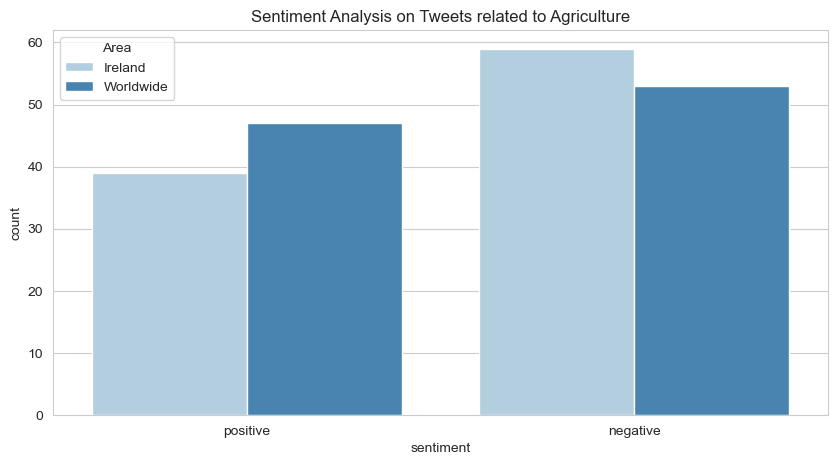

In [341]:
plt.figure(figsize=(10,5))
g = sns.countplot(data=total_tweets, x="sentiment", hue="Area", palette="Blues");
g.set_title('Sentiment Analysis on Tweets related to Agriculture')

plt.show();